In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("../../lib")

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import temporal_encoder_common
import nonneg_common
import lif_utils
import nengo
import dlop_ldn_function_bases as bases

In [60]:
n_neurons = 1000
n_temporal_dimensions = q = 5
n_dimensions = d = 2
tau = 0.1

def mk_encs(n, d, rng=np.random):
    encs = rng.normal(0, 1, (n, d))
    encs /= np.linalg.norm(encs, axis=1)[:, None]
    return encs

gains, biases, _ = nonneg_common.mk_ensemble(n_neurons, d=1)
Es = mk_encs(n_neurons, q * d)

In [10]:
A, B = bases.mk_ldn_lti(n_temporal_dimensions)

In [37]:
Ap = np.zeros((q * d, q * d))
Bp = np.zeros((q * d, d))
for i in range(d):
    Ap[(i * q):((i+1) * q), (i * q):((i+1) * q)] = tau * A + np.eye(q)
    Bp[(i * q):((i+1) * q), i] = tau * B

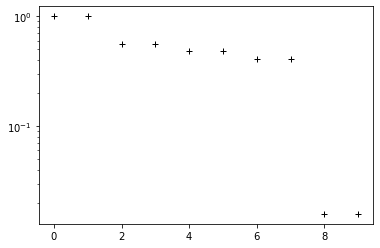

In [38]:
U, S, V = np.linalg.svd(Ap)
fig, ax = plt.subplots()
ax.plot(S / np.max(S), 'k+')
ax.set_yscale('log')

In [79]:
with nengo.Network() as model:
    nd_in = nengo.Node(size_in=n_dimensions)
    for i in range(n_dimensions):
        nd_noise = nengo.Node(nengo.processes.WhiteSignal(period=100.0, high=1.0, y0=0.0, rms=0.5))
        nengo.Connection(nd_noise, nd_in[i], synapse=None)
    
    ens_x = nengo.Ensemble(
        n_neurons=n_neurons,
        dimensions=n_dimensions * n_temporal_dimensions,
        bias=biases,
        gain=gains,
        encoders=Es,
    )

    nengo.Connection(nd_in, ens_x, transform=Bp, synapse=tau)
    nengo.Connection(ens_x, ens_x, transform=Ap, synapse=tau)

    p_in = nengo.Probe(nd_in, synapse=None)
    p_out_neurons = nengo.Probe(ens_x.neurons, synapse=None)

with nengo.Simulator(model) as sim:
    sim.run(10.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [80]:
def shift(xs, t, dt=1e-3):
    N = xs.shape[0]
    N_shift = int(t / dt)
    return np.concatenate((np.zeros(N_shift), xs))[:N]

In [81]:
ts = sim.trange()
xs = sim.data[p_in]
As = sim.data[p_out_neurons]

xs_flt = nengo.Lowpass(100e-3).filtfilt(xs, dt=1e-3)
As_flt = nengo.Lowpass(100e-3).filtfilt(As, dt=1e-3)

xs_flt_s1 = shift(xs_flt[:, 0], 0.1)
xs_flt_s2 = shift(xs_flt[:, 1], 0.1)

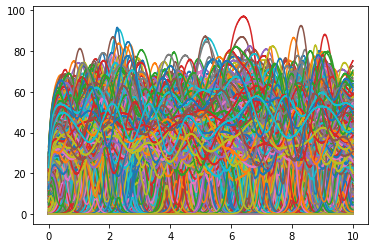

In [82]:
fig, ax = plt.subplots()
ax.plot(ts, As_flt);

In [77]:
D = np.linalg.lstsq(As_flt, xs_flt_s1 * xs_flt_s2, rcond=1e-2)[0]

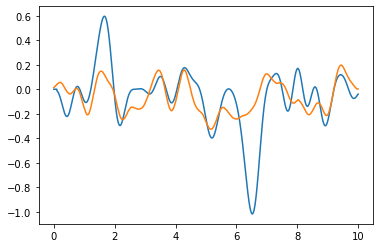

In [83]:
fig, ax = plt.subplots()
ax.plot(ts, xs_flt_s1 * xs_flt_s2)
ax.plot(ts, As_flt @ D)